In [186]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

# Preprocessing
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Metric
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, make_scorer, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

from scipy.stats import kruskal, mannwhitneyu

from sklearn.ensemble import StackingClassifier, VotingClassifier

import warnings
warnings.filterwarnings('ignore')

---
# Exercise: Ensemble Model

Anda bekerja sebagai data scientist di perusahaan asuransi. Anda diminta untuk memprediksi apakah seorang calon nasabah akan mengajukan klaim ketika dia memiliki asuransi atau tidak. 

- Dataset: Car_Insurance_Claim.csv
- Target: 'OUTCOME'

Coba gunakan ensemble model yang sudah kita pelajari hari ini.

In [124]:
df = pd.read_csv('Car_Insurance_Claim.csv')

In [125]:
df.isna().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [126]:
df.duplicated().sum()

0

## EDA

In [127]:
# unique values in categorical columns

for i in df.describe(include='object').columns:
    print(i, '\n', df[i].unique(), '\n')

AGE 
 ['65+' '16-25' '26-39' '40-64'] 

GENDER 
 ['female' 'male'] 

RACE 
 ['majority' 'minority'] 

DRIVING_EXPERIENCE 
 ['0-9y' '10-19y' '20-29y' '30y+'] 

EDUCATION 
 ['high school' 'none' 'university'] 

INCOME 
 ['upper class' 'poverty' 'working class' 'middle class'] 

VEHICLE_YEAR 
 ['after 2015' 'before 2015'] 

VEHICLE_TYPE 
 ['sedan' 'sports car'] 



In [128]:
# missing values

df.isna().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [129]:
df.corr()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,1.000000,0.001704,0.009197,0.014826,0.001233,0.006038,-0.002217,0.008156,0.009268,0.001831,-0.010506
CREDIT_SCORE,0.001704,1.000000,0.312037,0.281238,0.220658,0.009040,-0.174453,0.204542,0.127366,0.180978,-0.325286
VEHICLE_OWNERSHIP,0.009197,0.312037,1.000000,0.175626,0.125990,-0.004866,-0.097433,0.133868,0.086567,0.119521,-0.378921
MARRIED,0.014826,0.281238,0.175626,1.000000,0.287009,0.012045,-0.462193,0.218855,0.120840,0.215269,-0.262104
CHILDREN,0.001233,0.220658,0.125990,0.287009,1.000000,0.020911,-0.447655,0.220415,0.115354,0.206295,-0.232835
POSTAL_CODE,0.006038,0.009040,-0.004866,0.012045,0.020911,1.000000,-0.133978,0.113686,0.038492,-0.116985,0.095889
ANNUAL_MILEAGE,-0.002217,-0.174453,-0.097433,-0.462193,-0.447655,-0.133978,1.000000,-0.323547,-0.116598,-0.195217,0.187154
SPEEDING_VIOLATIONS,0.008156,0.204542,0.133868,0.218855,0.220415,0.113686,-0.323547,1.000000,0.359838,0.443074,-0.291862
DUIS,0.009268,0.127366,0.086567,0.120840,0.115354,0.038492,-0.116598,0.359838,1.000000,0.259359,-0.189352
PAST_ACCIDENTS,0.001831,0.180978,0.119521,0.215269,0.206295,-0.116985,-0.195217,0.443074,0.259359,1.000000,-0.311495


In [130]:
# plt.figure(figsize = (20,20))
# sns.heatmap(df.sort_values('MARRIED')[['CREDIT_SCORE','ANNUAL_MILEAGE']].isna())

In [131]:
df['MARRIED'].value_counts()

# Data cukup balance

0.0    5018
1.0    4982
Name: MARRIED, dtype: int64

In [132]:
df['MARRIED'].sort_values()

0       0.0
4151    0.0
4150    0.0
4149    0.0
7958    0.0
       ... 
4485    1.0
4484    1.0
4483    1.0
4499    1.0
9999    1.0
Name: MARRIED, Length: 10000, dtype: float64

In [133]:
# untuk dimasukkan pada simple imputer
df[df['MARRIED']==1]['ANNUAL_MILEAGE'].median()

10000.0

In [134]:
df['ANNUAL_MILEAGE'].median()

12000.0

<AxesSubplot: xlabel='CREDIT_SCORE', ylabel='Count'>

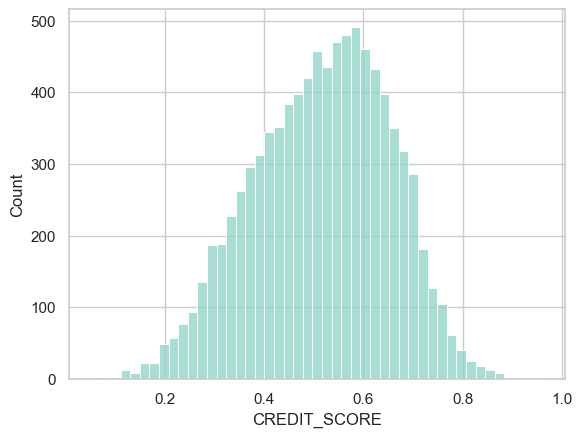

In [135]:
sns.histplot(data=df, x='CREDIT_SCORE')

In [136]:
print(df['CREDIT_SCORE'].mean())
print(df['CREDIT_SCORE'].median())

0.515812809602791
0.5250327586154788


<AxesSubplot: xlabel='ANNUAL_MILEAGE', ylabel='Count'>

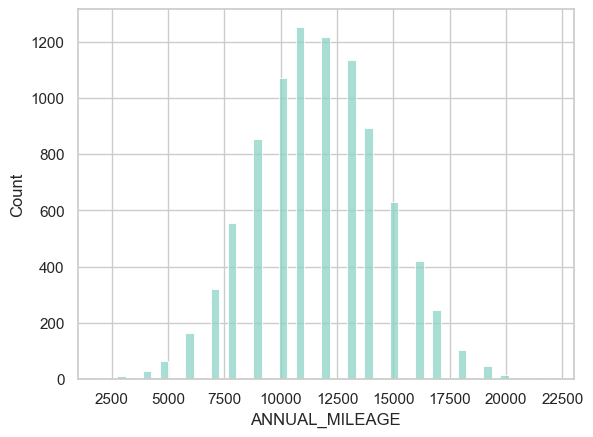

In [137]:
sns.histplot(data=df, x='ANNUAL_MILEAGE')

In [138]:
print(df['ANNUAL_MILEAGE'].mean())
print(df['ANNUAL_MILEAGE'].median())
print(df['ANNUAL_MILEAGE'].mode()[0])


11697.003206900365
12000.0
11000.0


In [139]:
# Outcome

df['OUTCOME'].value_counts()

# mild imbalance

0.0    6867
1.0    3133
Name: OUTCOME, dtype: int64

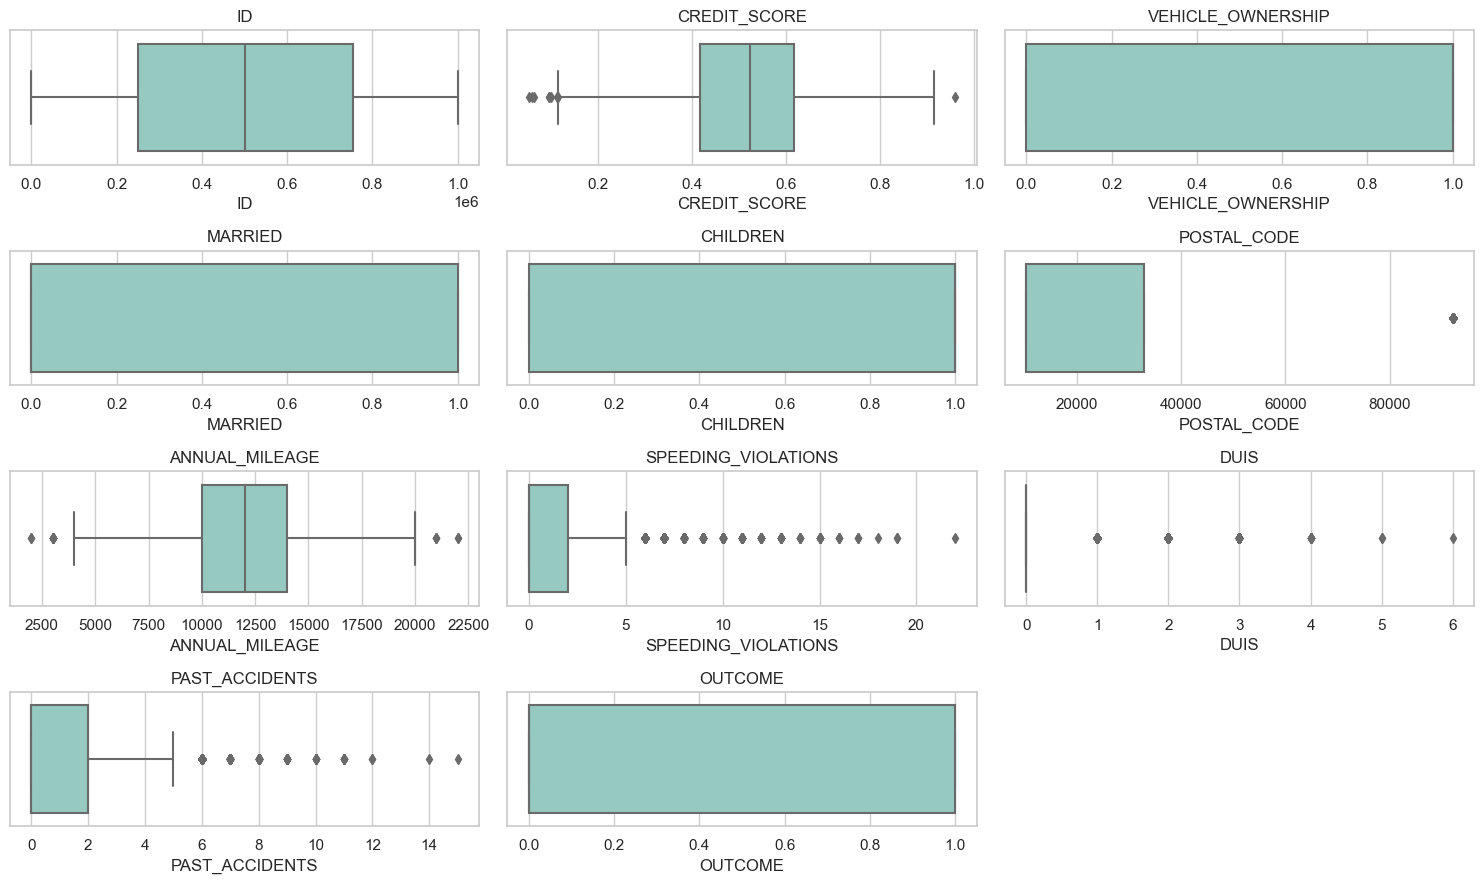

In [140]:
# Numerical Features
num_feature = [fea for fea in df.describe().columns]
num_feature

plt.figure(figsize=(15, 9), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(4,3, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=12)
    plt.tight_layout()
    plotnumber += 1

In [141]:
df.duplicated().sum()

0

In [142]:
df['POSTAL_CODE'].nunique()

4

# Data Splitting

In [143]:
df.head(1)

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0


In [144]:
X = df.drop(columns=['ID','OUTCOME'])

y = df['OUTCOME']

In [145]:
df['OUTCOME'].unique()

array([0., 1.])

In [146]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [147]:
y.value_counts()

0.0    6867
1.0    3133
Name: OUTCOME, dtype: int64

In [148]:
X.isna().sum()

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
dtype: int64

In [149]:
X.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
0,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0
1,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0
2,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0
3,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0
4,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1


In [150]:
df.describe().columns

Index(['ID', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')

In [151]:
# # ordinal mapping 1
# ordinal_mapping1 = [
#     {'col':'AGE', 'mapping':{'16-25':20, '26-39':33, '40-64':47, '65+':70, None:0}},
#     {'col':'DRIVING_EXPERIENCE', 'mapping':{'0-9y':5, '10-19y':15, '20-29y':25 , '30y+':35, None:0}},
#     {'col':'EDUCATION', 'mapping':{'high school':12, 'university':16, 'none':0, None:0}},
#     {'col':'INCOME', 'mapping':{'poverty':1, 'working class':2, 'middle class':3, 'upper class':4, None:0}} 
# ] 

# ordinal mapping 2
ordinal_mapping2 = [
    {'col':'AGE', 'mapping':{'16-25':1, '26-39':2, '40-64':3, '65+':4, None:0}},
    {'col':'DRIVING_EXPERIENCE', 'mapping':{'0-9y':1, '10-19y':2, '20-29y':3 , '30y+':4, None:0}},
    {'col':'EDUCATION', 'mapping':{'high school':1, 'university':2, 'none':0, None:0}},
    {'col':'INCOME', 'mapping':{'poverty':1, 'working class':2, 'middle class':3, 'upper class':4, None:0}} 
] 

In [152]:
X.isna().sum()

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
dtype: int64

In [155]:
pipe_median_scale = Pipeline([
    ('median', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

pipe_ordinal_scale = Pipeline([
    ('ordinal', OrdinalEncoder(cols=['AGE','DRIVING_EXPERIENCE','EDUCATION','INCOME'], mapping=ordinal_mapping2)),
    ('scaler', RobustScaler())
])

transformer = ColumnTransformer([
    ('pipe_median_scale', pipe_median_scale, ['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']),
    ('pipe_ordinal_scale', pipe_ordinal_scale, ['AGE','DRIVING_EXPERIENCE','EDUCATION','INCOME']),
    ('onehot', OneHotEncoder(drop='first'), ['GENDER', 'RACE', 'VEHICLE_YEAR','VEHICLE_TYPE', 'POSTAL_CODE'])
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipe_median_scale',
                                 Pipeline(steps=[('median',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
                                  'MARRIED', 'CHILDREN', 'ANNUAL_MILEAGE',
                                  'SPEEDING_VIOLATIONS', 'DUIS',
                                  'PAST_ACCIDENTS']),
                                ('pipe_ordinal_scale',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder...
                                                                           'mapping': high school    1
university     2
none           0
None           0
dtype: int64},
                                                                          {'col': 'INCOME',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': poverty          1
working class    2
middle class     3
upper class      4
None             0
dtype: int64}])),
                                                 ('scaler', RobustScaler())]),
                                 ['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION',
                                  'INCOME']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['GENDER', 'RACE', 'VEHICLE_YEAR',
                                  'VEHICLE_TYPE', 'POSTAL_CODE'])])

# Cross validation

In [159]:
y_train.value_counts()

0.0    5494
1.0    2506
Name: OUTCOME, dtype: int64

In [172]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

model = [knn,tree,logreg]

list_all = []
list_mean = []
list_std = []

for i in model:
    
    model_pipe = Pipeline([
        ('transformer',transformer),
        ('sampling',RandomUnderSampler()),
        ('model', i)
    ])

    model_cv = cross_val_score(
        estimator=model_pipe,
        X = X_train,
        y = y_train,
        cv = 5,
        scoring = 'recall'
    )

    list_all.append(model_cv)
    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())

In [176]:
df_score = pd.DataFrame({
    'model':['knn', 'tree', 'logreg'],
    'mean':list_mean,
    'std':list_std,
    'all score': list_all
})

df_score

,model,mean,std,all score
0,knn,0.800488,0.012519,"[0.8023952095808383, 0.8043912175648703, 0.804..."
1,tree,0.832021,0.025765,"[0.8483033932135728, 0.8383233532934131, 0.824..."
2,logreg,0.872312,0.016796,"[0.8862275449101796, 0.8622754491017964, 0.856..."


# Model Dengan Stacking

In [182]:
list_all_clf = []

stacking_clf = StackingClassifier([
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

pipe_model = Pipeline([
    ('transformer',transformer),
    ('rus', RandomUnderSampler()),
    ('scaling',RobustScaler()),
    ('model',stacking_clf)
])

stacking_cv = cross_val_score(
    estimator=pipe_model,
    X=X_train,
    y = y_train,
    cv = 5,
    scoring = 'recall'
)

In [183]:
df_score.loc[3] = ['stacking',stacking_cv.mean(),stacking_cv.std(),stacking_cv.round(4)]

In [184]:
df_score

,model,mean,std,all score
0,knn,0.800488,0.012519,"[0.8023952095808383, 0.8043912175648703, 0.804..."
1,tree,0.832021,0.025765,"[0.8483033932135728, 0.8383233532934131, 0.824..."
2,logreg,0.872312,0.016796,"[0.8862275449101796, 0.8622754491017964, 0.856..."
3,stacking,0.857942,0.013006,"[0.8583, 0.8443, 0.8503, 0.8822, 0.8546]"


## modeling dengan voting

In [187]:
voting_clf = VotingClassifier([
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

pipe_model = Pipeline([
    ('transformer',transformer),
    ('rus', RandomUnderSampler()),
    ('scaling',RobustScaler()),
    ('model',voting_clf)
])

voting_cv = cross_val_score(
    estimator=pipe_model,
    X=X_train,
    y = y_train,
    cv = 5,
    scoring = 'recall'
)

In [188]:
df_score.loc[4] = ['voting',voting_cv.mean(),voting_cv.std(),voting_cv.round(4)]

In [189]:
df_score

,model,mean,std,all score
0,knn,0.800488,0.012519,"[0.8023952095808383, 0.8043912175648703, 0.804..."
1,tree,0.832021,0.025765,"[0.8483033932135728, 0.8383233532934131, 0.824..."
2,logreg,0.872312,0.016796,"[0.8862275449101796, 0.8622754491017964, 0.856..."
3,stacking,0.857942,0.013006,"[0.8583, 0.8443, 0.8503, 0.8822, 0.8546]"
4,voting,0.849557,0.010038,"[0.8503, 0.8363, 0.8403, 0.8623, 0.8586]"


## Hyperparameter Tuning

In [201]:
pipe_model = Pipeline([
    ('transformer',transformer),
    ('sampling', RandomUnderSampler()),
    ('scaling',RobustScaler()),
    ('model',LogisticRegression())
])


hyperparam_space = {
    'model__C': [1000,100,10,1,0,0.01,0.001],
    'model__solver': ['liblinear','newton-cg'],
    'transformer__pipe_median_scale__scaler': [RobustScaler(),MinMaxScaler(),StandardScaler()],
    'transformer__pipe_ordinal_scale__scaler': [RobustScaler(),MinMaxScaler(),StandardScaler()],
    'sampling': [RandomUnderSampler(), RandomOverSampler(),PolynomialFeatures()]
    }

grid_search = GridSearchCV(
        model_pipe,
        param_grid=hyperparam_space,
        cv = 5,
        scoring = 'recall',
        n_jobs = -1
    )

In [202]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipe_median_scale',
                                                                         Pipeline(steps=[('median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['CREDIT_SCORE',
                                                                          'VEHICLE_OWNERSHIP',
                                                                          'MARRIED',
                                                                          'CHILDREN',
                                                                          'ANNUAL_MILEAGE',
                                                                          'SPEEDING_VIOLATIONS',
                                                                          'DUIS',
                                                                          'PAST_ACCIDENTS']),
                                                                        ('pi...
             param_grid={'model__C': [1000, 100, 10, 1, 0, 0.01, 0.001],
                         'model__solver': ['liblinear', 'newton-cg'],
                         'sampling': [RandomUnderSampler(), RandomOverSampler(),
                                      PolynomialFeatures()],
                         'transformer__pipe_median_scale__scaler': [RobustScaler(),
                                                                    MinMaxScaler(),
                                                                    StandardScaler()],
                         'transformer__pipe_ordinal_scale__scaler': [RobustScaler(),
                                                                     MinMaxScaler(),
                                                                     StandardScaler()]},
             scoring='recall')

In [203]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,param_sampling,param_transformer__pipe_median_scale__scaler,param_transformer__pipe_ordinal_scale__scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
58,0.172040,0.005923,0.033121,0.004089,100,liblinear,RandomUnderSampler(),MinMaxScaler(),MinMaxScaler(),"{'model__C': 100, 'model__solver': 'liblinear'...",0.878244,0.860279,0.860279,0.908184,0.854582,0.872314,0.019626,1
7,0.192989,0.012702,0.033207,0.005692,1000,liblinear,RandomUnderSampler(),StandardScaler(),MinMaxScaler(),"{'model__C': 1000, 'model__solver': 'liblinear...",0.884232,0.858283,0.858283,0.900200,0.860558,0.872311,0.017039,2
3,0.166381,0.015478,0.032601,0.003263,1000,liblinear,RandomUnderSampler(),MinMaxScaler(),RobustScaler(),"{'model__C': 1000, 'model__solver': 'liblinear...",0.878244,0.856287,0.854291,0.904192,0.868526,0.872308,0.018151,3
59,0.347451,0.098348,0.045444,0.019423,100,liblinear,RandomUnderSampler(),MinMaxScaler(),StandardScaler(),"{'model__C': 100, 'model__solver': 'liblinear'...",0.880240,0.860279,0.858283,0.904192,0.856574,0.871914,0.018263,4
168,0.171741,0.009595,0.032713,0.003302,1,liblinear,RandomUnderSampler(),StandardScaler(),RobustScaler(),"{'model__C': 1, 'model__solver': 'liblinear', ...",0.886228,0.852295,0.864271,0.898204,0.856574,0.871514,0.017742,5


In [204]:
print('Best score:', grid_search.best_score_)
print('Best params:', grid_search.best_params_)

Best score: 0.8723135402501768
Best params: {'model__C': 100, 'model__solver': 'liblinear', 'sampling': RandomUnderSampler(), 'transformer__pipe_median_scale__scaler': MinMaxScaler(), 'transformer__pipe_ordinal_scale__scaler': MinMaxScaler()}


## Predict to test set sebelum tuning

In [207]:
# stacking (ensemble)
stacking_clf = StackingClassifier([
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

pipe_model = Pipeline([
    ('transformer',transformer),
    ('sampling', RandomUnderSampler()),
    ('scaling',RobustScaler()),
    ('model',LogisticRegression())
])

pipe_model.fit(X_train,y_train)

y_pred_before = pipe_model.predict(X_test)

recall_score(y_test,y_pred_before)

0.8596491228070176

## Predict to test set setelah tuning dengan best model

In [208]:
best_model = grid_search.best_estimator_

best_model.fit(X_train,y_train)

y_pred_after = best_model.predict(X_test)

recall_score(y_test,y_pred_after)



0.8628389154704944